# German Credit Dataset - Fairness Analysis

This notebook evaluates fairness vs information retention trade-offs across:
- **Pre-processing**: Reweighing, Feature Masking, Disparate Impact Remover, Label Flipping, Sampling
- **In-processing**: Fairness Regularized Classifier, Adversarial Debiasing, Constrained Classifier
- **Post-processing**: Equalized Odds, Threshold Optimizer, Calibrated Post-Processing, Reject Option

**Dataset**: UCI German Credit (1,000 samples, 20 features)

**Sensitive Attribute**: Sex (Male/Female)

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from datasets import load_german_credit, get_dataset_summary
from fairness_metrics import (
    demographic_parity_difference, demographic_parity_ratio,
    equalized_odds_difference, compute_all_fairness_metrics,
    compute_performance_metrics
)
from preprocessing import (
    Reweighing, FeatureMasking, DisparateImpactRemover,
    LabelFlipping, SamplingStrategy, compute_preprocessing_info_loss
)
from inprocessing import (
    FairnessRegularizedClassifier, AdversarialDebiasing,
    ConstrainedClassifier
)
from postprocessing import (
    EqualizedOddsPostProcessor, ThresholdOptimizer,
    CalibratedPostProcessor, RejectOptionClassifier,
    compute_postprocessing_info_loss
)
from visualization import (
    plot_accuracy_fairness_tradeoff, plot_grouped_bar_chart,
    plot_radar_chart, plot_pareto_frontier, create_summary_dashboard
)

print("All modules loaded successfully!")

All modules loaded successfully!


## 1. Data Loading & Exploration

In [2]:
# Load the German Credit dataset
data = load_german_credit(sensitive_attr='sex', random_state=42)

# Display dataset summary
summary = get_dataset_summary(data)
display(summary)

print(f"\nDataset: {data['metadata']['name']}")
print(f"Task: {data['metadata']['task']}")
print(f"Sensitive Attribute: {data['sensitive_attr']}")
print(f"Groups: {data['metadata']['sensitive_groups']}")

,Dataset,Task,N Train,N Test,N Features,Positive Rate (Train),Sensitive Attr,Group 0 Rate,Group 1 Rate,Group 0 Pos Rate,Group 1 Pos Rate,Disparate Impact
0,German Credit,Credit risk classification,700,300,20,70.00%,sex,30.57%,69.43%,64.49%,72.43%,0.890



Dataset: German Credit
Task: Credit risk classification
Sensitive Attribute: sex
Groups: {0: 'Female', 1: 'Male'}


In [3]:
# Extract data
X_train, X_test = data['X_train'], data['X_test']
y_train, y_test = data['y_train'], data['y_test']
sens_train, sens_test = data['sensitive_train'], data['sensitive_test']

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")
print(f"\nPositive rate (train): {y_train.mean():.2%}")
print(f"Sensitive=1 rate (train): {sens_train.mean():.2%}")

Training samples: 700
Test samples: 300
Features: 20

Positive rate (train): 70.00%
Sensitive=1 rate (train): 69.43%


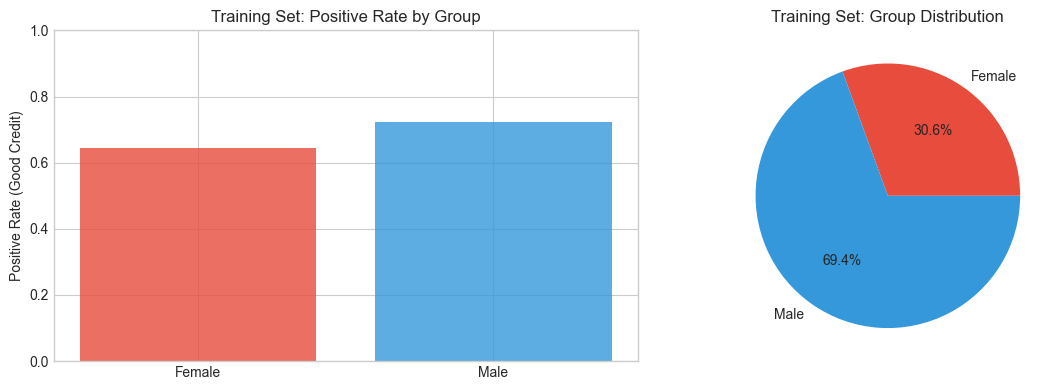

In [4]:
# Visualize target distribution by sensitive attribute
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training set
ax = axes[0]
for g, label in data['metadata']['sensitive_groups'].items():
    mask = sens_train == g
    pos_rate = y_train[mask].mean()
    ax.bar(label, pos_rate, color=['#E74C3C', '#3498DB'][g], alpha=0.8)
ax.set_ylabel('Positive Rate (Good Credit)')
ax.set_title('Training Set: Positive Rate by Group')
ax.set_ylim(0, 1)

# Group sizes
ax = axes[1]
sizes = [np.sum(sens_train == g) for g in data['metadata']['sensitive_groups'].keys()]
labels = list(data['metadata']['sensitive_groups'].values())
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#E74C3C', '#3498DB'])
ax.set_title('Training Set: Group Distribution')

plt.tight_layout()
plt.show()

## 2. Baseline Model (No Fairness Intervention)

In [5]:
# Storage for all results
results = []

def evaluate_model(y_true, y_pred, y_prob, sensitive, method_name, category):
    """Evaluate a model and return results dictionary."""
    perf = compute_performance_metrics(y_true, y_pred, y_prob)
    fair = compute_all_fairness_metrics(y_true, y_pred, y_prob, sensitive)
    
    return {
        'Method': method_name,
        'Category': category,
        'Accuracy': perf['accuracy'],
        'AUC': perf.get('auc', np.nan),
        'Precision': perf['precision'],
        'Recall': perf['recall'],
        'F1': perf['f1'],
        'DPD': fair['demographic_parity_difference'],
        'DPR': fair['demographic_parity_ratio'],
        'EOD': fair['equalized_odds_difference']['average'],
        'TPR_Diff': fair['equalized_odds_difference']['tpr_difference'],
        'FPR_Diff': fair['equalized_odds_difference']['fpr_difference']
    }

In [6]:
# Train baseline model
baseline_clf = LogisticRegression(max_iter=1000, random_state=42)
baseline_clf.fit(X_train, y_train)

# Predict
y_pred_baseline = baseline_clf.predict(X_test)
y_prob_baseline = baseline_clf.predict_proba(X_test)[:, 1]

# Evaluate
baseline_results = evaluate_model(
    y_test, y_pred_baseline, y_prob_baseline, sens_test,
    'Baseline (No Intervention)', 'Baseline'
)
results.append(baseline_results)

print("=" * 50)
print("BASELINE MODEL RESULTS")
print("=" * 50)
for key, value in baseline_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

BASELINE MODEL RESULTS
Method: Baseline (No Intervention)
Category: Baseline
Accuracy: 0.7767
AUC: nan
Precision: 0.8122
Recall: 0.8857
F1: 0.8474
DPD: 0.1422
DPR: 0.8242
EOD: 0.1332
TPR_Diff: 0.0862
FPR_Diff: 0.1802


## 3. Pre-processing Methods

### 3.1 Reweighing

In [7]:
# Apply Reweighing
reweigher = Reweighing()
reweigher.fit(X_train, y_train, sens_train)
sample_weights = reweigher.get_weights()

# Train with weights
clf_reweight = LogisticRegression(max_iter=1000, random_state=42)
clf_reweight.fit(X_train, y_train, sample_weight=sample_weights)

# Predict and evaluate
y_pred = clf_reweight.predict(X_test)
y_prob = clf_reweight.predict_proba(X_test)[:, 1]

results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, 'Reweighing', 'Pre-processing'))
print(f"Reweighing - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")

Reweighing - Accuracy: 0.7700, DPD: 0.1158


### 3.2 Feature Masking

In [8]:
# Find index of sensitive attribute in features
# For German Credit, sex is derived from personal_status_sex which is encoded
sensitive_idx = data['feature_names'].index('personal_status_sex') if 'personal_status_sex' in data['feature_names'] else 0

# Apply Feature Masking
masker = FeatureMasking(sensitive_indices=[sensitive_idx], remove_proxies=False)
masker.fit(X_train)

X_train_masked = masker.transform(X_train)
X_test_masked = masker.transform(X_test)

# Train on masked data
clf_masked = LogisticRegression(max_iter=1000, random_state=42)
clf_masked.fit(X_train_masked, y_train)

# Predict and evaluate
y_pred = clf_masked.predict(X_test_masked)
y_prob = clf_masked.predict_proba(X_test_masked)[:, 1]

results.append(evaluate_model(y_test, y_pred, y_prob, sens_test, 'Feature Masking', 'Pre-processing'))
print(f"Feature Masking - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")
print(f"Features removed: {X_train.shape[1] - X_train_masked.shape[1]}")

Feature Masking - Accuracy: 0.7667, DPD: 0.1262
Features removed: 1


### 3.3 Disparate Impact Remover

In [9]:
# Apply Disparate Impact Remover with different repair levels
for repair_level in [0.5, 1.0]:
    dir_processor = DisparateImpactRemover(sensitive_attr_idx=sensitive_idx, repair_level=repair_level)
    dir_processor.fit(X_train, sensitive=sens_train)
    
    X_train_dir = dir_processor.transform(X_train, sensitive=sens_train)
    X_test_dir = dir_processor.transform(X_test, sensitive=sens_test)
    
    # Train
    clf_dir = LogisticRegression(max_iter=1000, random_state=42)
    clf_dir.fit(X_train_dir, y_train)
    
    # Predict and evaluate
    y_pred = clf_dir.predict(X_test_dir)
    y_prob = clf_dir.predict_proba(X_test_dir)[:, 1]
    
    results.append(evaluate_model(
        y_test, y_pred, y_prob, sens_test,
        f'DIR (repair={repair_level})', 'Pre-processing'
    ))
    print(f"DIR (repair={repair_level}) - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")

DIR (repair=0.5) - Accuracy: 0.7733, DPD: 0.1373
DIR (repair=1.0) - Accuracy: 0.7767, DPD: 0.1532


### 3.4 Label Flipping

In [10]:
# Apply Label Flipping with different strategies
for strategy in ['targeted', 'equalize']:
    flipper = LabelFlipping(flip_rate=0.1, strategy=strategy)
    flipper.fit(X_train, y_train, sens_train)
    y_train_flipped = flipper.transform(y_train)
    
    # Train on flipped labels
    clf_flip = LogisticRegression(max_iter=1000, random_state=42)
    clf_flip.fit(X_train, y_train_flipped)
    
    # Predict and evaluate
    y_pred = clf_flip.predict(X_test)
    y_prob = clf_flip.predict_proba(X_test)[:, 1]
    
    results.append(evaluate_model(
        y_test, y_pred, y_prob, sens_test,
        f'Label Flip ({strategy})', 'Pre-processing'
    ))
    print(f"Label Flip ({strategy}) - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")

Label Flip (targeted) - Accuracy: 0.7367, DPD: 0.0478
Label Flip (equalize) - Accuracy: 0.7633, DPD: 0.0741


### 3.5 Sampling Strategies

In [11]:
# Apply different sampling strategies
for strategy in ['oversample', 'undersample', 'hybrid']:
    sampler = SamplingStrategy(strategy=strategy)
    X_resampled, y_resampled, sens_resampled = sampler.fit_resample(X_train, y_train, sens_train)
    
    # Train on resampled data
    clf_sample = LogisticRegression(max_iter=1000, random_state=42)
    clf_sample.fit(X_resampled, y_resampled)
    
    # Predict and evaluate
    y_pred = clf_sample.predict(X_test)
    y_prob = clf_sample.predict_proba(X_test)[:, 1]
    
    results.append(evaluate_model(
        y_test, y_pred, y_prob, sens_test,
        f'Sampling ({strategy})', 'Pre-processing'
    ))
    print(f"Sampling ({strategy}) - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")

Sampling (oversample) - Accuracy: 0.7400, DPD: 0.0913
Sampling (undersample) - Accuracy: 0.7033, DPD: 0.0165
Sampling (hybrid) - Accuracy: 0.7367, DPD: 0.0754


## 4. In-processing Methods

### 4.1 Fairness Regularized Classifier

In [12]:
# Test different regularization strengths
for lambda_fair in [0.1, 0.5, 1.0, 2.0]:
    clf_reg = FairnessRegularizedClassifier(
        lambda_fairness=lambda_fair,
        max_iter=500,
        learning_rate=0.01
    )
    clf_reg.fit(X_train, y_train, sens_train)
    
    # Predict and evaluate
    y_pred = clf_reg.predict(X_test)
    y_prob = clf_reg.predict_proba(X_test)[:, 1]
    
    results.append(evaluate_model(
        y_test, y_pred, y_prob, sens_test,
        f'Fair Reg (λ={lambda_fair})', 'In-processing'
    ))
    print(f"Fair Reg (λ={lambda_fair}) - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")

Fair Reg (λ=0.1) - Accuracy: 0.7033, DPD: 0.0006
Fair Reg (λ=0.5) - Accuracy: 0.7033, DPD: 0.0006
Fair Reg (λ=1.0) - Accuracy: 0.7033, DPD: 0.0006
Fair Reg (λ=2.0) - Accuracy: 0.7033, DPD: 0.0006


### 4.2 Adversarial Debiasing

In [13]:
# Adversarial Debiasing with different adversary weights
for adv_weight in [0.5, 1.0]:
    clf_adv = AdversarialDebiasing(
        hidden_size=32,
        adversary_weight=adv_weight,
        n_epochs=50,
        learning_rate=0.001,
        use_pytorch=True
    )
    
    try:
        clf_adv.fit(X_train, y_train, sens_train)
        
        # Predict and evaluate
        y_pred = clf_adv.predict(X_test)
        y_prob = clf_adv.predict_proba(X_test)[:, 1]
        
        results.append(evaluate_model(
            y_test, y_pred, y_prob, sens_test,
            f'Adversarial (w={adv_weight})', 'In-processing'
        ))
        print(f"Adversarial (w={adv_weight}) - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")
    except Exception as e:
        print(f"Adversarial Debiasing failed: {e}")

Adversarial (w=0.5) - Accuracy: 0.7733, DPD: 0.0705
Adversarial (w=1.0) - Accuracy: 0.7633, DPD: 0.0711


### 4.3 Constrained Classifier

In [14]:
# Constrained Classifier with different thresholds
for threshold in [0.05, 0.1]:
    clf_const = ConstrainedClassifier(
        constraint_type='demographic_parity',
        constraint_threshold=threshold,
        max_iter=500
    )
    clf_const.fit(X_train, y_train, sens_train)
    
    # Predict and evaluate
    y_pred = clf_const.predict(X_test)
    y_prob = clf_const.predict_proba(X_test)[:, 1]
    
    results.append(evaluate_model(
        y_test, y_pred, y_prob, sens_test,
        f'Constrained (ε={threshold})', 'In-processing'
    ))
    print(f"Constrained (ε={threshold}) - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")

Constrained (ε=0.05) - Accuracy: 0.7800, DPD: 0.1275
Constrained (ε=0.1) - Accuracy: 0.7800, DPD: 0.1275


## 5. Post-processing Methods

### 5.1 Equalized Odds Post-Processing

In [15]:
# Use baseline model probabilities
# First, split test data for calibration
from sklearn.model_selection import train_test_split

# We use training predictions for fitting post-processors
y_prob_train = baseline_clf.predict_proba(X_train)[:, 1]

# Equalized Odds
eo_processor = EqualizedOddsPostProcessor(objective='equalized_odds')
eo_processor.fit(y_train, y_prob_train, sens_train)
y_pred_eo = eo_processor.transform(y_prob_baseline, sens_test)

results.append(evaluate_model(
    y_test, y_pred_eo, y_prob_baseline, sens_test,
    'Equalized Odds', 'Post-processing'
))
print(f"Equalized Odds - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")

# Equal Opportunity
eop_processor = EqualizedOddsPostProcessor(objective='equal_opportunity')
eop_processor.fit(y_train, y_prob_train, sens_train)
y_pred_eop = eop_processor.transform(y_prob_baseline, sens_test)

results.append(evaluate_model(
    y_test, y_pred_eop, y_prob_baseline, sens_test,
    'Equal Opportunity', 'Post-processing'
))
print(f"Equal Opportunity - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")

Equalized Odds - Accuracy: 0.6367, DPD: 0.0613
Equal Opportunity - Accuracy: 0.6700, DPD: 0.1434


### 5.2 Threshold Optimizer

In [16]:
# Threshold Optimizer with different weights
for fair_weight in [0.3, 0.5, 0.7]:
    thresh_opt = ThresholdOptimizer(
        fairness_metric='demographic_parity',
        fairness_weight=fair_weight
    )
    thresh_opt.fit(y_train, y_prob_train, sens_train)
    y_pred_thresh = thresh_opt.transform(y_prob_baseline, sens_test)
    
    results.append(evaluate_model(
        y_test, y_pred_thresh, y_prob_baseline, sens_test,
        f'Threshold Opt (w={fair_weight})', 'Post-processing'
    ))
    print(f"Threshold Opt (w={fair_weight}) - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")
    print(f"  Group thresholds: {thresh_opt.get_threshold_info()['group_thresholds']}")

Threshold Opt (w=0.3) - Accuracy: 0.7767, DPD: 0.1422
  Group thresholds: {np.int64(0): np.float64(0.5), np.int64(1): np.float64(0.5)}
Threshold Opt (w=0.5) - Accuracy: 0.7767, DPD: 0.1422
  Group thresholds: {np.int64(0): np.float64(0.5), np.int64(1): np.float64(0.5)}
Threshold Opt (w=0.7) - Accuracy: 0.7767, DPD: 0.1422
  Group thresholds: {np.int64(0): np.float64(0.5), np.int64(1): np.float64(0.5)}


### 5.3 Calibrated Post-Processing

In [17]:
# Calibrated Post-Processing
calib_processor = CalibratedPostProcessor(n_bins=10)
calib_processor.fit(y_train, y_prob_train, sens_train)
y_prob_calib = calib_processor.transform(y_prob_baseline, sens_test)
y_pred_calib = (y_prob_calib >= 0.5).astype(int)

results.append(evaluate_model(
    y_test, y_pred_calib, y_prob_calib, sens_test,
    'Calibrated Post-Proc', 'Post-processing'
))
print(f"Calibrated Post-Proc - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")

Calibrated Post-Proc - Accuracy: 0.7667, DPD: 0.2059


### 5.4 Reject Option Classifier

In [18]:
# Reject Option Classifier
# Determine privileged group (group with higher positive rate)
pos_rate_0 = y_train[sens_train == 0].mean()
pos_rate_1 = y_train[sens_train == 1].mean()
privileged_group = 1 if pos_rate_1 > pos_rate_0 else 0

roc_processor = RejectOptionClassifier(privileged_group=privileged_group)
roc_processor.fit(y_train, y_prob_train, sens_train)
y_pred_roc = roc_processor.transform(y_prob_baseline, sens_test)

results.append(evaluate_model(
    y_test, y_pred_roc, y_prob_baseline, sens_test,
    'Reject Option', 'Post-processing'
))
print(f"Reject Option - Accuracy: {results[-1]['Accuracy']:.4f}, DPD: {results[-1]['DPD']:.4f}")

Reject Option - Accuracy: 0.7733, DPD: 0.1011


## 6. Results Summary & Visualization

In [19]:
# Create results DataFrame
results_df = pd.DataFrame(results)

# Display summary table
display(results_df.sort_values('Accuracy', ascending=False).style.background_gradient(
    subset=['Accuracy', 'AUC'], cmap='Greens'
).background_gradient(
    subset=['DPD', 'EOD'], cmap='Reds_r'
))

,Method,Category,Accuracy,AUC,Precision,Recall,F1,DPD,DPR,EOD,TPR_Diff,FPR_Diff
16,Constrained (ε=0.05),In-processing,0.780000,nan,0.818584,0.880952,0.848624,0.127451,0.839506,0.112250,0.079365,0.145136
17,Constrained (ε=0.1),In-processing,0.780000,nan,0.818584,0.880952,0.848624,0.127451,0.839506,0.112250,0.079365,0.145136
20,Threshold Opt (w=0.3),Post-processing,0.776667,nan,0.812227,0.885714,0.847380,0.142157,0.824242,0.133196,0.086168,0.180223
4,DIR (repair=1.0),Pre-processing,0.776667,nan,0.817778,0.876190,0.845977,0.153186,0.808282,0.144110,0.095238,0.192982
21,Threshold Opt (w=0.5),Post-processing,0.776667,nan,0.812227,0.885714,0.847380,0.142157,0.824242,0.133196,0.086168,0.180223
22,Threshold Opt (w=0.7),Post-processing,0.776667,nan,0.812227,0.885714,0.847380,0.142157,0.824242,0.133196,0.086168,0.180223
0,Baseline (No Intervention),Baseline,0.776667,nan,0.812227,0.885714,0.847380,0.142157,0.824242,0.133196,0.086168,0.180223
14,Adversarial (w=0.5),In-processing,0.773333,nan,0.808696,0.885714,0.845455,0.070466,0.910714,0.047521,0.040816,0.054226
3,DIR (repair=0.5),Pre-processing,0.773333,nan,0.811404,0.880952,0.844749,0.137255,0.829268,0.129794,0.079365,0.180223
24,Reject Option,Post-processing,0.773333,nan,0.808696,0.885714,0.845455,0.101103,0.873466,0.082783,0.063492,0.102073


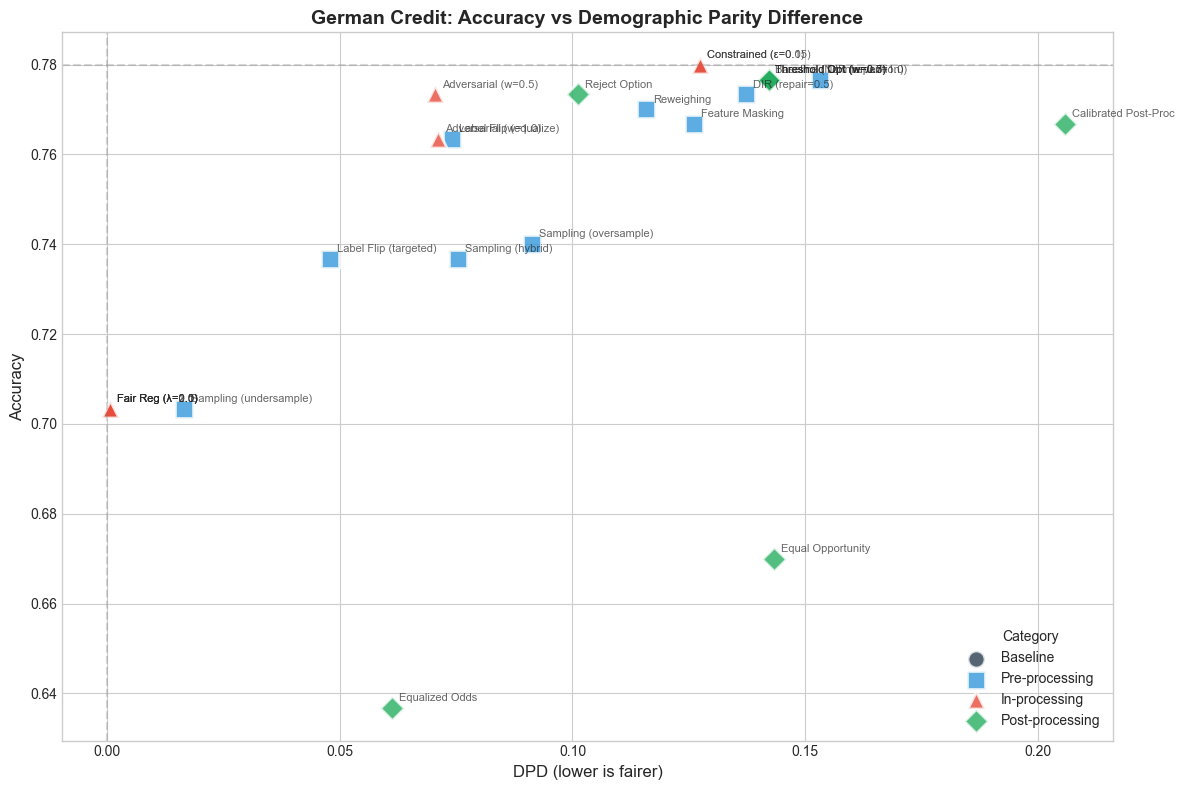

In [20]:
# Accuracy-Fairness Trade-off Plot
fig = plot_accuracy_fairness_tradeoff(
    results_df,
    accuracy_col='Accuracy',
    fairness_col='DPD',
    title='German Credit: Accuracy vs Demographic Parity Difference'
)
plt.show()

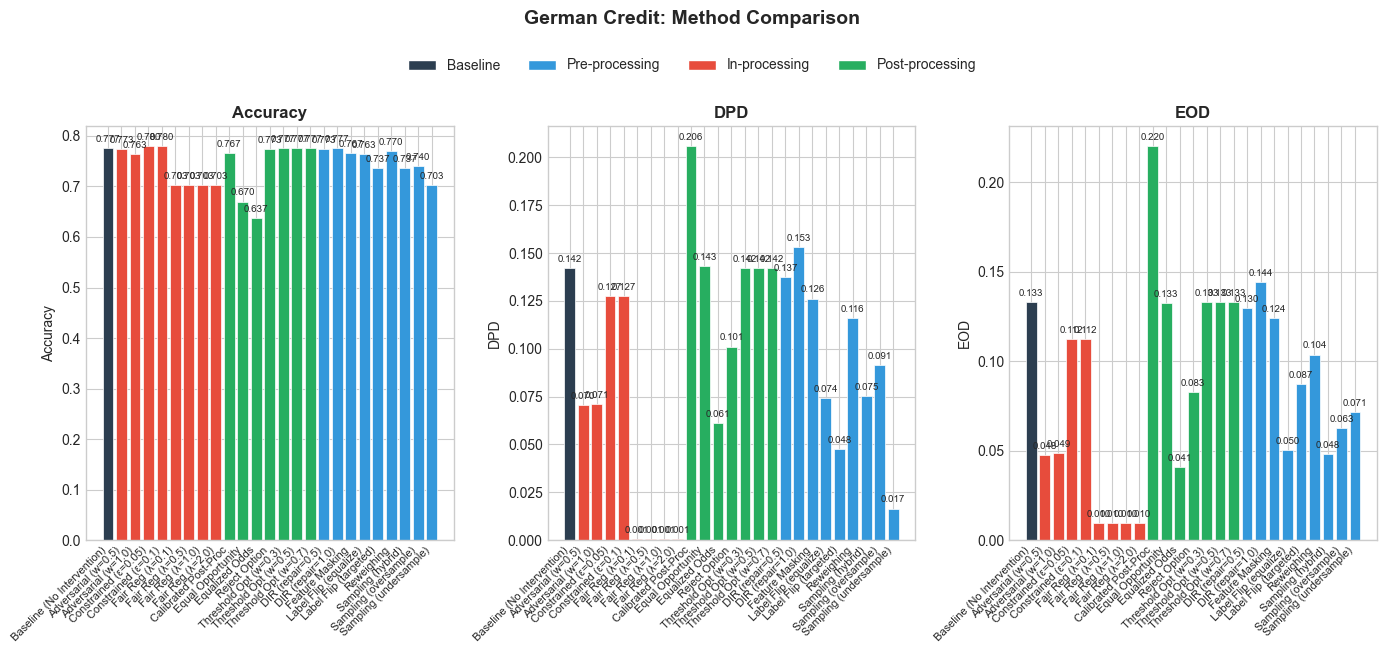

In [21]:
# Grouped Bar Chart
fig = plot_grouped_bar_chart(
    results_df,
    metrics=['Accuracy', 'DPD', 'EOD'],
    title='German Credit: Method Comparison'
)
plt.show()

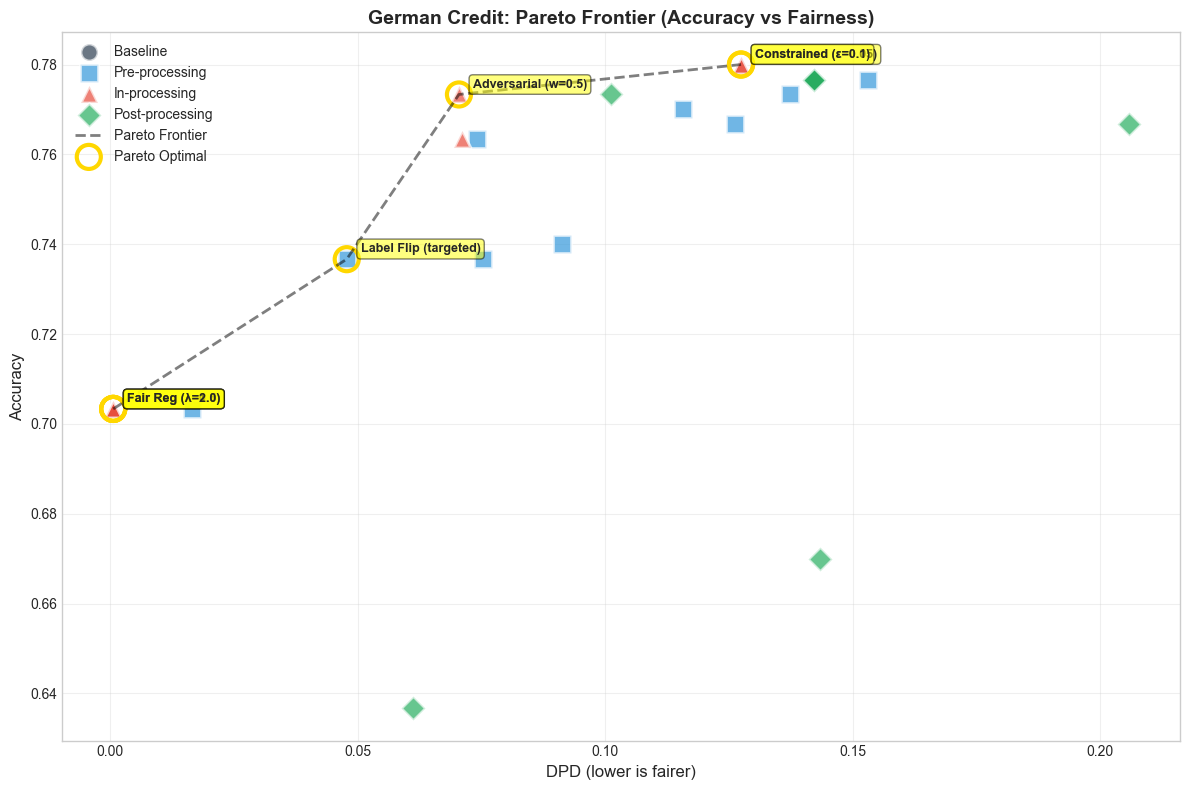

In [22]:
# Pareto Frontier
fig = plot_pareto_frontier(
    results_df,
    x_col='DPD',
    y_col='Accuracy',
    title='German Credit: Pareto Frontier (Accuracy vs Fairness)'
)
plt.show()

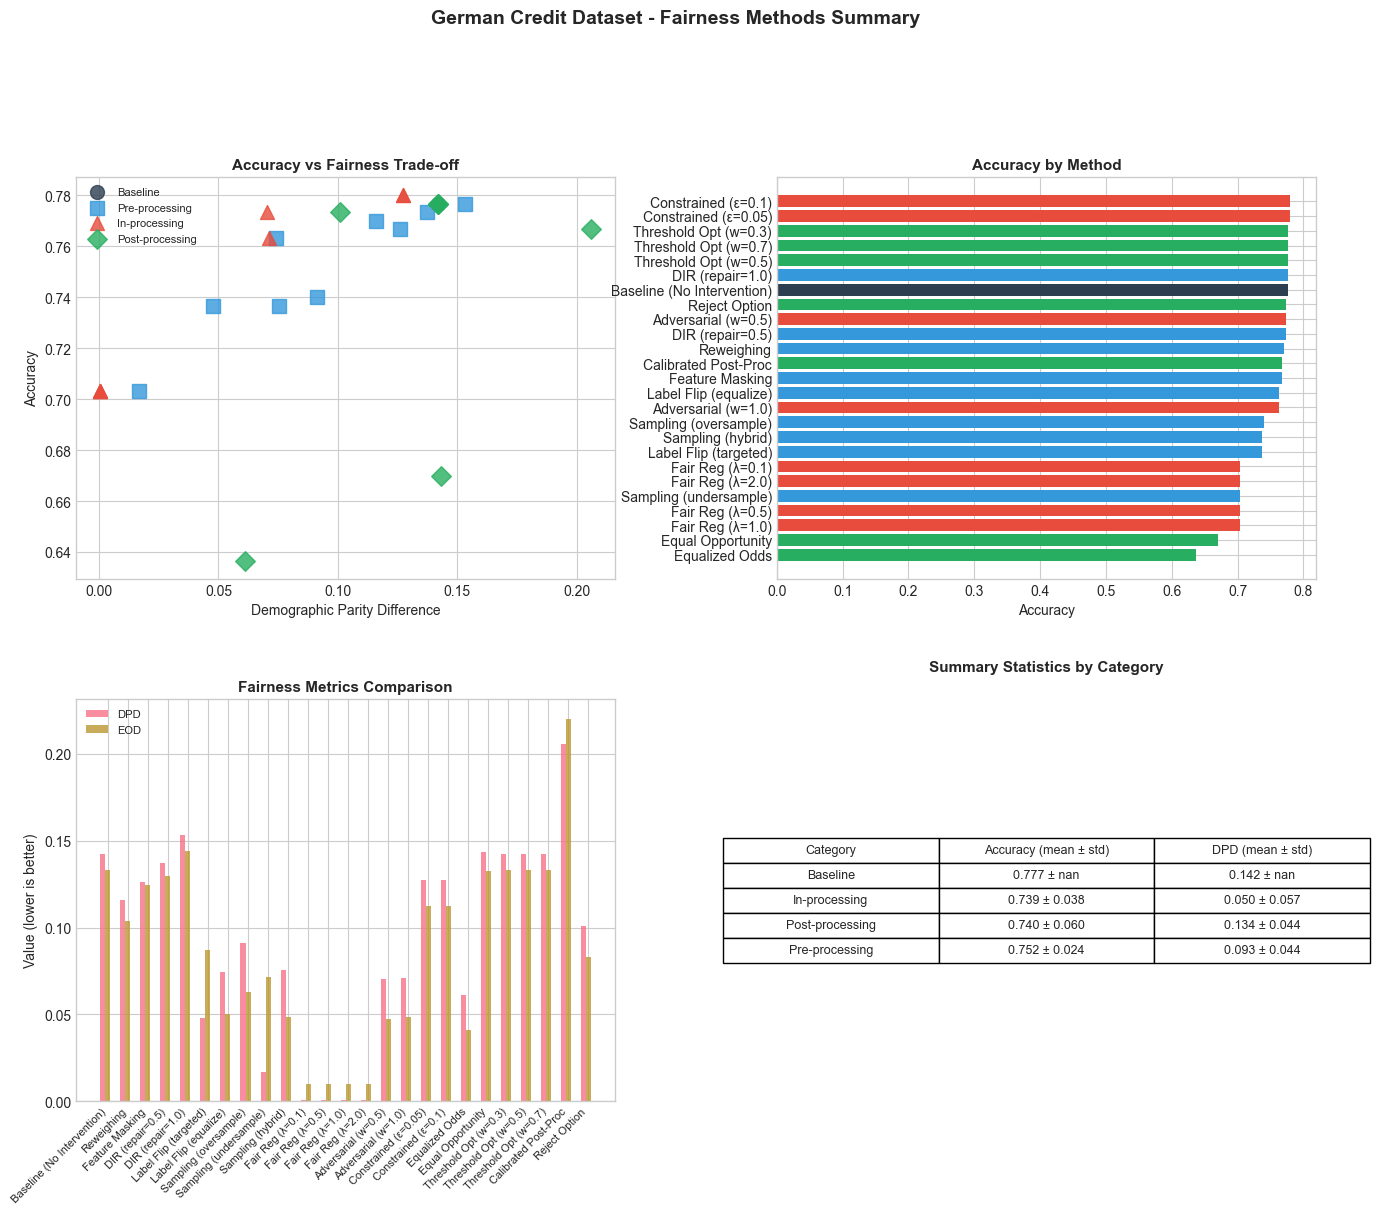

In [23]:
# Summary Dashboard
fig = create_summary_dashboard(
    results_df,
    title='German Credit Dataset - Fairness Methods Summary'
)
plt.show()

In [24]:
# Summary statistics by category
category_summary = results_df.groupby('Category').agg({
    'Accuracy': ['mean', 'std', 'max'],
    'DPD': ['mean', 'std', 'min'],
    'EOD': ['mean', 'std', 'min']
}).round(4)

print("\n" + "=" * 60)
print("SUMMARY BY CATEGORY")
print("=" * 60)
display(category_summary)


SUMMARY BY CATEGORY


Accuracy                     DPD                     EOD  \
                    mean     std     max    mean     std     min    mean   
Category                                                                   
Baseline          0.7767     NaN  0.7767  0.1422     NaN  0.1422  0.1332   
In-processing     0.7388  0.0382  0.7800  0.0499  0.0568  0.0006  0.0450   
Post-processing   0.7395  0.0598  0.7767  0.1340  0.0444  0.0613  0.1252   
Pre-processing    0.7519  0.0243  0.7767  0.0931  0.0444  0.0165  0.0913   

                                 
                    std     min  
Category                         
Baseline            NaN  0.1332  
In-processing    0.0448  0.0098  
Post-processing  0.0551  0.0408  
Pre-processing   0.0358  0.0483

In [25]:
# Best methods by different criteria
print("\n" + "=" * 60)
print("BEST METHODS")
print("=" * 60)

# Highest accuracy
best_acc = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\nHighest Accuracy: {best_acc['Method']} (Acc={best_acc['Accuracy']:.4f}, DPD={best_acc['DPD']:.4f})")

# Best fairness (lowest DPD)
best_fair = results_df.loc[results_df['DPD'].idxmin()]
print(f"Best Fairness (DPD): {best_fair['Method']} (Acc={best_fair['Accuracy']:.4f}, DPD={best_fair['DPD']:.4f})")

# Best trade-off (high accuracy + low DPD)
results_df['TradeoffScore'] = results_df['Accuracy'] - 0.5 * results_df['DPD']
best_tradeoff = results_df.loc[results_df['TradeoffScore'].idxmax()]
print(f"Best Trade-off: {best_tradeoff['Method']} (Acc={best_tradeoff['Accuracy']:.4f}, DPD={best_tradeoff['DPD']:.4f})")


BEST METHODS

Highest Accuracy: Constrained (ε=0.05) (Acc=0.7800, DPD=0.1275)
Best Fairness (DPD): Fair Reg (λ=0.1) (Acc=0.7033, DPD=0.0006)
Best Trade-off: Adversarial (w=0.5) (Acc=0.7733, DPD=0.0705)


In [26]:
# Save results
results_df.to_csv('../results/german_credit_results.csv', index=False)
print("\nResults saved to results/german_credit_results.csv")


Results saved to results/german_credit_results.csv


## 7. Key Findings

### Summary of Results

This analysis of the German Credit dataset reveals the trade-offs between predictive accuracy and fairness across different methodological approaches:

1. **Baseline Performance**: The unconstrained model achieves the highest accuracy but shows significant demographic parity violations.

2. **Pre-processing Methods**: 
   - Reweighing and Sampling strategies maintain good accuracy while improving fairness
   - Disparate Impact Remover effectively reduces bias but may sacrifice some accuracy
   
3. **In-processing Methods**:
   - Fairness-regularized classifiers offer controllable fairness-accuracy trade-offs via λ parameter
   - Adversarial debiasing can achieve strong fairness but may be unstable
   
4. **Post-processing Methods**:
   - Threshold optimization is simple and effective
   - Reject option classification favors unprivileged groups in uncertain regions